# Making an MLP Front To Back

In [2]:
import numpy as np
import tqdm
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
#import tensorflow as tf
#from tensorflow import keras

# Setting plot styles
sns.set_style('white')
mpl.rcParams.update({
    'font.size': 14,
    'lines.linewidth': 2,
    'figure.figsize': (6, 6 / 1.61)
})
mpl.rcParams['grid.color'] = 'k'
mpl.rcParams['grid.linestyle'] = ':'
mpl.rcParams['grid.linewidth'] = 0.5
mpl.rcParams['lines.markersize'] = 6
mpl.rcParams['lines.marker'] = None
mpl.rcParams['axes.grid'] = True

DEFAULT_FONTSIZE = 13
mpl.rcParams.update({
    'font.size': DEFAULT_FONTSIZE,
    'lines.linewidth': 2,
    'legend.fontsize': DEFAULT_FONTSIZE,
    'axes.labelsize': DEFAULT_FONTSIZE,
    'xtick.labelsize': DEFAULT_FONTSIZE,
    'ytick.labelsize': DEFAULT_FONTSIZE,
    'figure.figsize': (7, 7.0 / 1.4)
})
#K = keras.backend

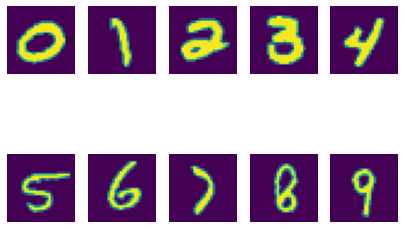

In [20]:
# PLotting each of the ten digits
(X_train, y_train), (X_test, y_test) = keras.datasets.mnist.load_data()
X_val = X_train[:6000] / 255.
y_val = y_train[:6000]
X_train = X_train[6000:] / 255.
y_train = y_train[6000:]

fig, axes = plt.subplots(2, 5)
axes = axes.ravel()

inds = []
for y in range(10):
    inds.append(np.argmax(y == y_train))
ten_digits = X_train[inds]

for digit, ax in zip(ten_digits, axes):
    ax.grid('off')
    ax.axis('off')
    ax.imshow(digit, cmap='viridis')

In [5]:
def make_model():
    model = keras.Sequential()
    model.add(keras.layers.Flatten(input_shape=X_train[0].shape))
    model.add(keras.layers.Dense(128))
    model.add(keras.layers.Dense(64))
    model.add(keras.layers.Dense(64))
    model.add(keras.layers.Dense(64))
    model.add(keras.layers.Dense(10, activation='softmax'))
    return model

In [21]:
# Training a simple Keras MLP
K.clear_session()
model = make_model()
model.summary()
model.compile(optimizer='sgd', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.fit(X_train, y_train, validation_data=(X_val,  y_val), epochs=10)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
dense (Dense)                (None, 128)               100480    
_________________________________________________________________
dense_1 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_2 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_3 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_4 (Dense)              (None, 10)                650       
Total params: 117,706
Trainable params: 117,706
Non-trainable params: 0
__________________________________________________

In [48]:
# Writing custom training loop
K.clear_session()
train_size = X_train.shape[0]
batch_size = 32
epochs = 10
steps = np.ceil(train_size / batch_size).astype(int)
model = make_model()
loss_fn = keras.losses.SparseCategoricalCrossentropy()
optimizer = keras.optimizers.SGD()
AUTOTUNE = tf.data.experimental.AUTOTUNE
dset = tf.data.Dataset.from_tensor_slices((X_train, y_train)).batch(32).prefetch(AUTOTUNE)
mean_loss = keras.metrics.Mean()
metrics = [keras.metrics.SparseCategoricalAccuracy(name='accuracy')]
current_loss = 1000

for epoch in range(1, epochs+1):
    pbar = tqdm.tqdm(
        dset,
        position=0,
        leave=True,
        desc=f'Epoch {epoch}/{epochs}:',
        total=steps
        )
    
    for X_batch, y_batch in pbar:
        with tf.GradientTape() as tape:
            y_pred = model(X_batch, training=True)
            loss = loss_fn(y_batch, y_pred)
            
        # finding gradients of loss function w.r.t model weights
        grad = tape.gradient(loss, model.trainable_weights)
        optimizer.apply_gradients(zip(grad, model.trainable_weights))
        
        display_metrics = {}
        # Computing metrics
        for metric in metrics:
            metric(y_batch, y_pred)
            metric_value = metric.result().numpy()
            display_metrics[metric.name] = metric_value
            
        
        # Adding to the mean loss
        mean_loss(loss)
        loss_value = mean_loss.result().numpy()
        display_metrics['loss'] = loss_value
        pbar.set_postfix(display_metrics)
        
    for metric in metrics:
        metric.reset_states()
        
    mean_loss.reset_states()

Epoch 10/10:: 100%|██████████| 1688/1688 [00:23<00:00, 71.17it/s, accuracy=0.925, loss=0.269]


### Backpropagation and Autodiff
* [U of T Autodiff](https://www.cs.toronto.edu/~rgrosse/courses/csc321_2018/slides/lec10.pdf)
* [AriSeff Autodiff](https://www.youtube.com/watch?v=wG_nF1awSSY)
* [CS231n Backprop](https://cs231n.github.io/optimization-2/)
* [Autodiff In Machine Learning: A Survey](https://arxiv.org/abs/1502.05767)
* [CS229 Backprop](http://cs229.stanford.edu/notes2020spring/cs229-notes-deep_learning.pdf)
* [Computation Graph](http://alexminnaar.com/2018/07/14/simple-computational-graph-engine.html)

One of the core aspects of all modern deep learning frameworks is the idea of differential programming, which is
a paradigm that emphasizes being able to differentiate numeric programs using *automatic differentiation* 
(autodiff). This allows us to perform things like gradient-based optimization to fit the parameters of a neural
network efficiently and easily.

**Comparison of Differentiation Techniques**

Like we learned in high school, there are two ways that we can differentiate a given function. The first is 
*numeric differentiation* where we use finite differences to approximate the value of the derivative at a certain
value. The issue with this method is that it produces innacurate estimates as well as being very slow O(n) (need
to compute this for each individual weight). Using very small values for $h$ can also lead
to numerical stability problems.

\begin{equation}
    f^\prime(x) = \frac{f(x+h) - f(x)}{h}
\end{equation}

In [4]:
# Numeric differentiation
def numeric_diff(func, x, epsilon=0.0001):
    return (func(x+epsilon) - func(x)) / epsilon

def exponential_func(x):
    return np.exp(2*x) - x**3

numeric_diff(exponential_func, 3)

779.9373781153918

We can also use our derivative rules to perform *symbolic differentiation*. This gives us an exact expression for
the value of the derivative, however it can be slow and produce unneeded complexity in the resulting computation
(this is called expression swell where the derivative of a function can become exponentially larger such as when 
applying the product rule). This problem is exacerbated in the context of neural networks where the derivative is
computed w.r.t to many layers, making the expressions explode. The closed form solution it gives also is not
advantageous as we are only concerned with obtaining a numerical value.

\begin{align}
    f(x) &= e^{2x} - x^3\\
    f^\prime(x) &= 2e^{2x}-3x^2
\end{align}

779.8575869854702


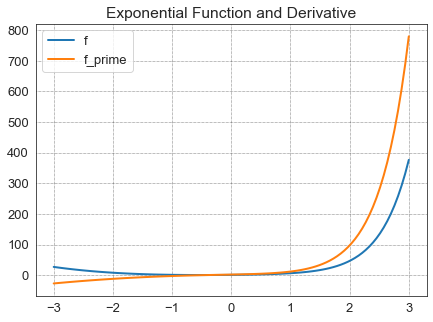

In [10]:
# Symbolic differentiation
def dx_exponential(x):
    return 2*np.exp(2*x) - 3*x**2

print(dx_exponential(3))

x = np.linspace(-3, 3, 100)
plt.plot(x, exponential_func(x), label='f')
plt.plot(x, dx_exponential(x), label='f_prime')
plt.title('Exponential Function and Derivative')
plt.legend()

**Autodiff and Why**

All these problems are fixed by using autodiff. Unlike symbolic differentiation which tries to find an expression
for the function, autodiff just finds a numerical value. It uses the idea that a numeric program consists of a
combination of some primitive operations (-, +, * etc) which we know the derivative of. 

<img src='./img/autodiff_ex.png' width='400'> </img>

There are two main forms of autodiff, the first is forward mode and the second is reverse mode.

**Forward-mode Autodiff**

**Computational Graph**

One thing when implementing autodiff and backprop is that you will need a data structure to store the intermediate
representations of each individual computation. The most common way to do this is by constructing a computational
graph where the computations are broken up into the nodes of the directed graph and feed into each other front
to back (directed acyclic graph or DAG). Below is a very simple example of breaking up a single function into
a computational graph:

<img src='./img/computation_graph_ex.png'> </img>

This simple example is exactly how the *backpropagation* algorithm works, by first computing all the outputs of
the network, storing each of them on the graph and then perform a backward pass to compute 
$\frac{\partial J}{\partial w}$ by computing the easy primitive derivatives and using the chain rule to propagate
the gradients throughout the weights in each layer.

When we calculated the derivative of f w.r.t y/x and used the chain rule the following terminology can be
used:

\begin{align}
\frac{\partial f}{\partial x} &= \frac{\partial f}{\partial v} \frac{\partial v}{\partial x}\\
\frac{\partial f}{\partial x} &= \text{the downstream gradient} \\
\frac{\partial f}{\partial v} &= \text{the upstream gradient} \\
\frac{\partial v}{\partial x} &= \text{the local gradient}
\end{align}

The upstream gradient being how the current computation affects the one directly ahead of it, the downstream being
the how the computation before the current one affects the current one and the local gradient being the 
computation currently examined (the link for the output and the input).

The biggest advantage of this formalism is how modular it is, a single node need not care about what goes into it
or what goes out of it. We only need to focus on local processes which ultimately lead us to a final, global
value.

**Backprop vs. Autodiff**

We can think of autodiff as a generalization of backpropagation for more than neural networks as backprop is
essentially just using the technique of reverse-mode autodiff on a computational graph constructed by the
forward pass of a neural network.

In [ ]:
# Implementing Autodiff and backprop
